In [1]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

In [2]:
filenames = glob("data/raw/BP_*_00A1.csv")

In [3]:
dataframes = [pd.read_csv(f, encoding='latin-1') for f in filenames]

In [4]:
for dataframe in dataframes:
    newcols = []
    for column in dataframe.columns:
        column = column.replace(".","").replace("-","").replace("_","")
        newcols.append(column)
    dataframe.columns = newcols   
  #  print(dataframe.columns)
    

In [5]:
dataframes2 =[]
for dataframe in dataframes:
    dataframe = dataframe[["GEOid2",
                           "GEOdisplaylabel",
                           "GEOfipsstatecode",
                           "GEOfipscountycode",
                           "NAICSdisplaylabel",
                           "ESTAB",
                           "EMP",
                           "YEARid"]]
    dataframe.columns = ["geo_id",
                       "county_name",
                       "state_fips",
                       "county_fips",
                       "naics_industry",
                       "establishments",
                       "employees",
                       "year"]
    dataframe = dataframe.set_index(["year"])
    
    #exclude state totals
    dataframe = dataframe[dataframe.county_fips != 999]
    
    #exclude puerto rico
    dataframe = dataframe[dataframe.state_fips != 72] 
    
    #exclude retired Alaskan Provinces
    dataframe = dataframe[dataframe.geo_id != 2201]
    dataframe = dataframe[dataframe.geo_id != 2232]
    dataframe = dataframe[dataframe.geo_id != 2280]
    
    #exclude totals
    dataframe = dataframe[dataframe.naics_industry != "Total for all sectors"]
    
    #apply updated NAICS sector code name
    dataframe.naics_industry = dataframe.naics_industry.str.replace("Mining","Mining, quarrying, and oil and gas extraction")

    #source typo corrections
    dataframe.county_name = dataframe.county_name.str.replace("Dona Ana County, New Mexico","Doña Ana County, New Mexico")
    dataframe.county_name = dataframe.county_name.str.replace("DoÃ±a Ana County, New Mexico","Doña Ana County, New Mexico")
    dataframe.county_name = dataframe.county_name.str.replace("La Salle County, Illinois","LaSalle County, Illinois")
    dataframe.county_name = dataframe.county_name.str.replace("La Salle Parish, Louisiana","LaSalle Parish, Louisiana")    
    
    dataframes2.append(dataframe)
    
    

In [6]:
stacked = pd.concat(dataframes2)

In [7]:
stacked.head()

,geo_id,county_name,state_fips,county_fips,naics_industry,establishments,employees
year,,,,,,,
2005,1001,"Autauga County, Alabama",1,1,"Agriculture, forestry, fishing and hunting",10,NaN
2005,1001,"Autauga County, Alabama",1,1,"Mining, quarrying, and oil and gas extraction",4,NaN
2005,1001,"Autauga County, Alabama",1,1,Utilities,8,NaN
2005,1001,"Autauga County, Alabama",1,1,Construction,119,642.0
2005,1001,"Autauga County, Alabama",1,1,Manufacturing,33,1623.0


In [8]:
yearly_establishments = stacked.groupby(("county_name","year")).sum()["establishments"]
county_list = stacked.groupby(("county_name","year")).sum()["establishments"].index.levels[0]

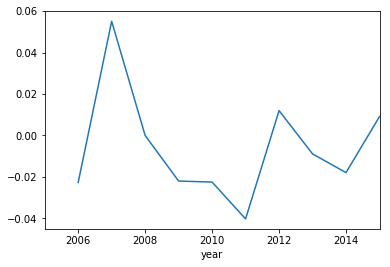

In [9]:
stacked.groupby(("county_name","year")).sum()["establishments"][county_list[0]].pct_change().plot()
plt.show()

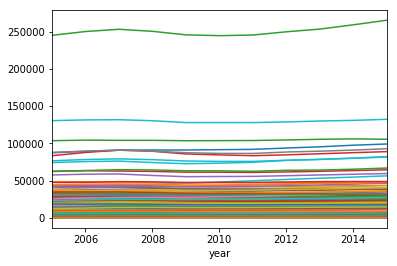

In [10]:
for county in county_list:
    yearly_establishments[county].plot()
plt.show()

In [11]:
county_establishments = yearly_establishments.reset_index("year")
establishments_2015 = county_establishments[county_establishments["year"] == 2015][["establishments"]]
establishments_2015.head()

,establishments
county_name,
"Abbeville County, South Carolina",332
"Acadia Parish, Louisiana",1122
"Accomack County, Virginia",738
"Ada County, Idaho",12757
"Adair County, Iowa",188


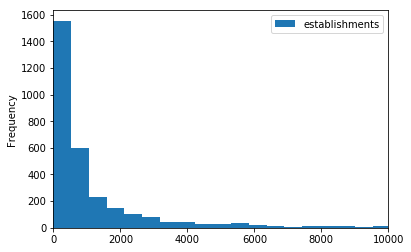

In [12]:
establishments_2015.plot(kind="hist", bins=500)
plt.axis(xmax=10000, xmin=0)
plt.show()

In [13]:
len(county_list)

3142

In [14]:
county_sets = []
for year in range(11):
    county_set = set(dataframes2[year].groupby(("county_name","year")).sum()["establishments"].index.levels[0])
    county_sets.append(county_set)
    print(len(county_set))

3135
3135
3136
3136
3136
3136
3135
3141
3142
3142
3142


In [15]:
print(county_sets[2] - county_sets[0])
print(county_sets[10] - county_sets[0])

{'Loving County, Texas'}
{'Loving County, Texas', 'Kalawao County, Hawaii', 'Hoonah-Angoon Census Area, Alaska', 'Wrangell City and Borough, Alaska', 'Prince of Wales-Hyder Census Area, Alaska', 'Skagway Municipality, Alaska', 'Petersburg Census Area, Alaska'}
